# ML Model for Soil Image Type Classification

In [1]:
train_data_directory = 'train'
test_data_directory = 'test'

In [2]:
import os # operating system
import re # regular expression
import cv2 # open cv
import time
import shutil # shell utility
import zipfile
import urllib.request
import numpy as np
from PIL import Image # python image library
from os import listdir
from os.path import isfile, join
from random import randrange # random range
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf

load_model = tf.keras.models.load_model
image = tf.keras.preprocessing.image
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
Sequential = tf.keras.models.Sequential
Dense = tf.keras.layers.Dense
Activation = tf.keras.layers.Activation
Flatten = tf.keras.layers.Flatten
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D

In [3]:
# initiate data preprocessing tools

training_data_processor  = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    zoom_range = 0.2,
    rotation_range = 10,
    shear_range = 0.2,
    height_shift_range = 0.1,
    width_shift_range = 0.1,
)

test_data_processor = ImageDataGenerator(rescale=1./255)


# load data into python

training_data = training_data_processor.flow_from_directory(
    train_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
)

testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size = (256, 256),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

Found 75 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


### Model building

In [4]:
# choose model parameters
num_conv_layers = 3
num_dense_layers = 1
layer_size = 32
num_training_epochs = 20
MODEL_NAME = 'soil'

In [5]:
# initiate model variable
model = Sequential()

# begin adding properties to model variable
# e.g. add a convulutional layer
model.add(Conv2D(layer_size, (3,3), input_shape=(256, 256, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# add additional convolutional layers based on num_conv_layers
for _ in range(num_conv_layers-1):
    model.add(Conv2D(layer_size, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

# reduce dimensionality
model.add(Flatten())

# add fully connected "dense" layers if specified
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))

# output layer
model.add(Dense(3))
model.add(Activation('softmax'))

# compile the sequential model with all added properties
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# use the data already loaded to train/tune the model
model.fit(
    training_data, 
    epochs = num_training_epochs, 
    validation_data = testing_data)

# save the trained model
model.save(f'{MODEL_NAME}.h5')

NameError: name 'scipy' is not defined

### Model testing

In [ ]:
def make_prediction(image_fp):
    im = cv2.imread(image_fp) # load the image from the given file path (image_fp)
    plt.imshow(im[:,:,[2,1,0]])
    img = image.load_img(image_fp, target_size = (256, 256))
    img = image.img_to_array(img)

    image_array = img / 255. # scale the image
    img_batch = np.expand_dims(image_array, axis = 0)

    class_ = ['Gravel', 'Sand', 'Silt'] # possible output values
    predicted_value = class_[model.predict(img_batch).argmax()]
    true_value = re.search(r'(Gravel)|(Sand)|(Silt)', image_fp)[0]
    out  = f"""
    Predicted type: {predicted_value}
    True soil type: {true_value}
    Correct: {predicted_value == true_value}
    """
    return out

1/1 [==============================] - 0s 72ms/step

    Predicted type: Sand
    True soil type: Sand
    Correct: True
    


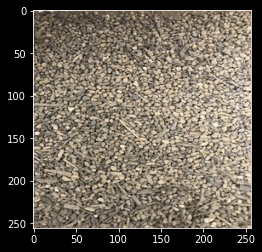

In [ ]:
test_image_file_path = test_data_directory + r'/Sand/0.jpg'
test_prediction = make_prediction(test_image_file_path)

print(test_prediction)

## Soil classification percentages
Soils are not perfectly homogenous (all one soil type). Soils are often a blend of types and may be better represented using a percentage. For example, the cell below shows a test photo labeled "silt"

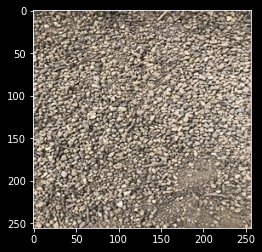

In [ ]:
percentage_photo = test_data_directory + r'/Silt/5.jpg'
percentage_photo2 = test_data_directory + r'/Sand/0.jpg'
percentage_photo3 = test_data_directory + r'/Gravel/0.jpg'
im = cv2.imread(percentage_photo2) # load image
plt.imshow(im[:,:,[2,1,0]])

# Subdividing an image
Run these cells below to subdivide the existing training photos into smaller segments. The new directory will be called `train_divided` and `test_divided`.

The image will be divided into smaller tiles and classify each tile and compute its fraction from the total number of tiles generated.

Note: this will take time (~30 sec to 2 minutes)

In [ ]:
def split_images(image_dir, save_dir):
    classification_list = ['Gravel', 'Sand', 'Silt']
    for class_ in classification_list:
        folder = image_dir + '/' + class_ + '/'
        save_folder = save_dir + '/' + class_ + '/'
        files = [f for f in listdir(folder) if isfile(join(folder, f))]

        for file in files:
            if '.ini' in file:
                continue
            fp = folder + file
            img = cv2.imread(fp)
            h,w,c = img.shape # height, width, color
            img_dim = 64
            # for cropping the images
            for r in range(0, img.shape[0], img_dim):
                for c in range(0, img.shape[1], img_dim):
                    cropped_img = img[r:r+img_dim, c:c+img_dim, :]
                    ch, cw, cc = cropped_img.shape
                    if ch == img_dim and cw == img_dim:
                        write_path = f"{save_folder + str(randrange(100000))}img{r}_{c}.jpg"
                        cv2.imwrite(write_path, cropped_img)
                    else: pass

In [ ]:
try:
    parent = train_data_directory.replace('train', '')
    dirs = ['train_divided', 'test_divided']
    class_ = ['Gravel', 'Sand', 'Silt']
    for dir in dirs:
        os.mkdir(os.path.join(parent, dir))
        for classification in class_:
            os.mkdir(os.path.join(parent, dir, classification))

    # split training data
    split_images(
        image_dir = train_data_directory,
        save_dir = train_data_directory.replace('train', 'train_divided'))

    # split test images
    split_images(
        image_dir = test_data_directory, 
        save_dir = test_data_directory.replace('test', 'test_divided'))

except FileExistsError:
    pass

### Load model

In [ ]:
model_fp = os.getcwd() + '/' + 'soil.h5'
print(model_fp)
model = load_model(model_fp)

c:\Users\ERIC ECHEMANE\Desktop\Projects\Model for Soil Type Classification\src/soil.h5


### Classify image
Use the loaded model to classify a test image. The function `classify_images` takes an image and a model and loops through each 256x256 square. It classifies each square and addes to the counter to create the fractional soil prediction. The function outputs the proportion of each soil type that was classified.

In [ ]:
def classify_images(image_fp, model):
    classes = ['Gravel', 'Sand', 'Silt']
    gravel_count = 0
    sand_count = 0
    silt_count = 0

    img = cv2.imread(image_fp)
    img = cv2.resize(img, (1024, 1024))
    img_dim = 256

    for r in range(0, img.shape[0], img_dim):
        for c in range(0, img.shape[1], img_dim):
            cropped_img = img[r:r + img_dim, c:c + img_dim, :]
            h,w,c = cropped_img.shape
            if h == img_dim and w == img_dim:
                classification = model_classify(cropped_img, model)
                if classification == classes[0]:
                    gravel_count += 1
                elif classification == classes[1]:
                    sand_count += 1
                elif classification == classes[2]:
                    silt_count += 1
                else:
                    continue

        total_count = gravel_count + sand_count + silt_count

        proportion_array = [
            gravel_count / total_count, 
            sand_count / total_count, 
            silt_count / total_count]

        return proportion_array

def model_classify(cropped_img, model):
    classes = ['Gravel', 'Sand', 'Silt']
    image_array = cropped_img / 256
    img_batch = np.expand_dims(image_array, axis=0)
    prediction_array = model.predict(img_batch)[0]
    first_index = np.argmax(prediction_array)
    first_class = classes[first_index]
    return first_class

def classify_percentage(image_fp):
    start = time.time()
    out = classify_images(image_fp=image_fp, model = model)
    finish = str(round(time.time() - start, 5))

    im = cv2.imread(image_fp) # load image
    plt.imshow(im[:,:,[2,1,0]])

    print(f'''---
    Percentage Classification Results

    Gravel: {round(out[0] * 100, 2)}%)
    Sand: {round(out[1] * 100, 2)}%)
    Silt: {round(out[2] * 100, 2)}%)

    Time it takes to classify: {finish} seconds
    ''')

1/1 [==============================] - 0s 27ms/step
---
    Percentage Classification Results

    Gravel: 75.0%)
    Sand: 0.0%)
    Silt: 25.0%)

    Time it takes to classify: 0.242 seconds
    


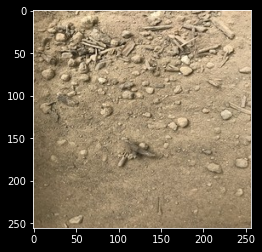

In [ ]:
classify_percentage(image_fp = percentage_photo)